In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import pdb
import glob
import natsort
from tqdm.notebook import tqdm
from nilearn import plotting as ni_plt
from pynwb import NWBHDF5IO
from ndx_events import LabeledEvents, AnnotatedEventsTable, Events

In [2]:
lp = '/data2/users/stepeter/files_nwb/downloads/000055/'
nparts = 12
allLH = False
nrows=3
width,height = 2.7*5,1.45*5
chan_labels='all'

In [3]:
def plot_ecog_electrodes_mni_from_nwb_file(nwb_dat,chan_labels='all',num_grid_chans=64,colors=None,node_size=50,
                                           figsize=(16,6),sides_2_display='auto',node_edge_colors=None,
                                           alpha=0.5,edge_linewidths=3,ax_in=None,rem_zero_chans=False,
                                           allLH=False,zero_rem_thresh=.99,elec_col_suppl=None):
    """
    Plots ECoG electrodes from MNI coordinate file (only for specified labels)
    
    Example code to run it: 
         import sys
         sys.path.append('/home/stepeter/AJILE/stepeter_sandbox/ECoG_Preprocessing')
         from Steve_libPreprocess import *
         subjID = 'a0f66459'
         day = '3'
         h5_fn='/nas/ecog_project/derived/processed_ecog/'+subjID+'/full_day_ecog/'+subjID+'_fullday_'+day+'.h5'
         chan_labels=list(['GRID1','GRID2']) #or chan_labels='all'
         plot_ecog_electrodes_mni_from_file_and_labels(h5_fn,chan_labels,num_grid_chans=64)
        
    NOTE: If running in Jupyter, use '%matplotlib inline' instead of '%matplotlib notebook'
    """ 
    #Load channel locations
    chan_info = nwb.electrodes.to_dataframe()
    
    #Create dataframe for electrode locations
    if chan_labels== 'all':
        locs = chan_info.loc[:,['x','y','z']]
    elif chan_labels== 'allgood':
        locs = chan_info.loc[:,['x','y','z','good']]
    else:
        locs = chan_info.loc[chan_labels,['x','y','z']]
    if (colors is not None):
        if (locs.shape[0]>len(colors)) & isinstance(colors, list):
            locs = locs.iloc[:len(colors),:]
#     locs.rename(columns={'X':'x','Y':'y','Z':'z'}, inplace=True)
    chan_loc_x = chan_info.loc[:,'x'].values
    
    #Remove NaN electrode locations (no location info)
    nan_drop_inds = np.nonzero(np.isnan(chan_loc_x))[0]
    locs.dropna(axis=0,inplace=True) #remove NaN locations
    if (colors is not None) & isinstance(colors, list):
        colors_new,loc_inds_2_drop = [],[]
        for s,val in enumerate(colors):
            if not (s in nan_drop_inds):
                colors_new.append(val)
            else:
                loc_inds_2_drop.append(s)
        colors = colors_new.copy()
        
        if elec_col_suppl is not None:
            loc_inds_2_drop.reverse() #go from high to low values
            for val in loc_inds_2_drop:
                del elec_col_suppl[val]
    
    if chan_labels=='allgood':
        goodChanInds = chan_info.loc[:,'good',:]
        inds2drop = np.nonzero(locs['good']==0)[0]
        locs.drop(columns=['good'],inplace=True)
        locs.drop(locs.index[inds2drop],inplace=True)
        
        if colors is not None:
            colors_new,loc_inds_2_drop = [],[]
            for s,val in enumerate(colors):
                if not (s in inds2drop):
#                     np.all(s!=inds2drop):
                    colors_new.append(val)
                else:
                    loc_inds_2_drop.append(s)
            colors = colors_new.copy()
            
            if elec_col_suppl is not None:
                loc_inds_2_drop.reverse() #go from high to low values
                for val in loc_inds_2_drop:
                    del elec_col_suppl[val]
    
    if rem_zero_chans:
        #Remove channels with zero values (white colors)
        colors_new,loc_inds_2_drop = [],[]
        for s,val in enumerate(colors):
            if np.mean(val)<zero_rem_thresh:
                colors_new.append(val)
            else:
                loc_inds_2_drop.append(s)
        colors = colors_new.copy()
        locs.drop(locs.index[loc_inds_2_drop],inplace=True)
        
        if elec_col_suppl is not None:
            loc_inds_2_drop.reverse() #go from high to low values
            for val in loc_inds_2_drop:
                del elec_col_suppl[val]
    
    #Decide whether to plot L or R hemisphere based on x coordinates
    if len(sides_2_display)>1:
        N,axes,sides_2_display = _setup_subplot_view(locs,sides_2_display,figsize)
    else:
        N = 1
        axes = ax_in
        if allLH:
            average_xpos_sign = np.mean(np.asarray(locs['x']))
            if average_xpos_sign>0:
                locs['x'] = -locs['x']
            sides_2_display ='l'
                
    if colors is None:
        colors = list()
    
    #Label strips/depths differently for easier visualization (or use defined color list)
    if len(colors)==0:
        for s in range(locs.shape[0]):
            if s>=num_grid_chans:
                colors.append('r')
            else:
                colors.append('b')
    
    if elec_col_suppl is not None:
        colors = elec_col_suppl.copy()
    
    #Rearrange to plot non-grid electrode first
    if num_grid_chans>0: #isinstance(colors, list):
        locs2 = locs.copy()
        locs2['x'] = np.concatenate((locs['x'][num_grid_chans:],locs['x'][:num_grid_chans]),axis=0)
        locs2['y'] = np.concatenate((locs['y'][num_grid_chans:],locs['y'][:num_grid_chans]),axis=0)
        locs2['z'] = np.concatenate((locs['z'][num_grid_chans:],locs['z'][:num_grid_chans]),axis=0)
        
        if isinstance(colors, list):
            colors2 = colors.copy()
            colors2 = colors[num_grid_chans:]+colors[:num_grid_chans]
        else:
            colors2 = colors
    else:
        locs2 = locs.copy()
        if isinstance(colors, list):
            colors2 = colors.copy()
        else:
            colors2 = colors #[colors for i in range(locs2.shape[0])]
    
    #Plot the result
    _plot_electrodes(locs2,node_size,colors2,axes,sides_2_display,N,node_edge_colors,alpha,edge_linewidths)


def _plot_electrodes(locs,node_size,colors,axes,sides_2_display,N,node_edge_colors,alpha,edge_linewidths,marker='o'):
    """
    Handles plotting
    """
    if N==1:
        ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                               node_kwargs={'alpha': alpha, 'edgecolors': node_edge_colors,'linewidths':edge_linewidths,'marker': marker},
                               node_size=node_size, node_color=colors,axes=axes,display_mode=sides_2_display)
    elif sides_2_display=='yrz' or sides_2_display=='ylz':
        colspans=[5,6,5] #different sized subplot to make saggital view similar size to other two slices
        current_col=0
        total_colspans=int(np.sum(np.asarray(colspans)))
        for ind,colspan in enumerate(colspans):
            axes[ind]=plt.subplot2grid((1,total_colspans), (0,current_col), colspan=colspan, rowspan=1)
            ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                               node_kwargs={'alpha': alpha, 'edgecolors': node_edge_colors,'linewidths':edge_linewidths,'marker': marker},
                               node_size=node_size, node_color=colors,axes=axes[ind],display_mode=sides_2_display[ind])
            current_col+=colspan
    else:
        for i in range(N):
            ni_plt.plot_connectome(np.eye(locs.shape[0]), locs, output_file=None,
                                   node_kwargs={'alpha': alpha, 'edgecolors': node_edge_colors,'linewidths':edge_linewidths,'marker': marker},
                                   node_size=node_size, node_color=colors,axes=axes[i],display_mode=sides_2_display[i])

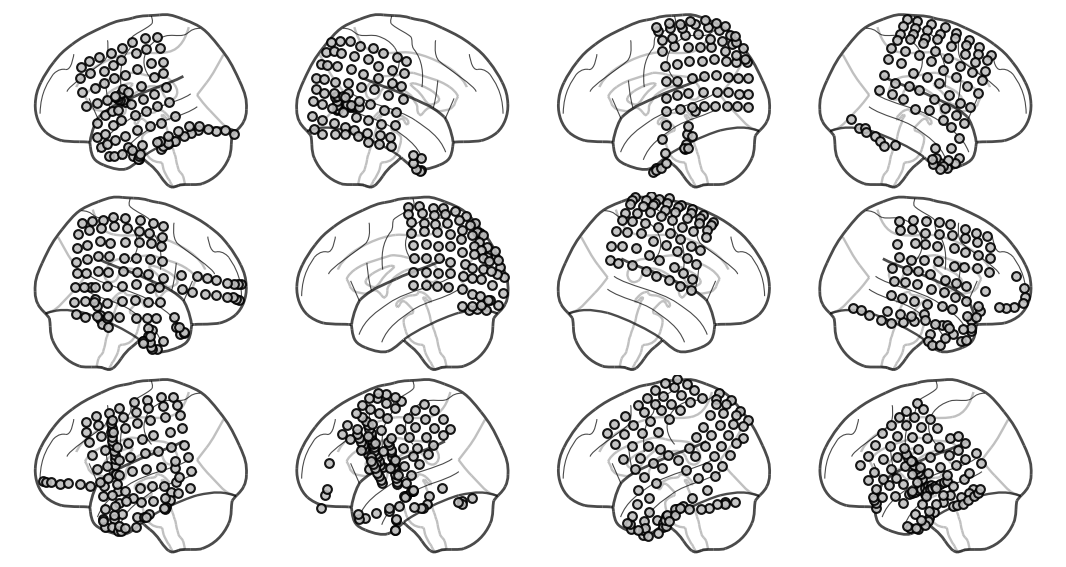

In [4]:
fig = plt.figure(figsize=(width,height), dpi=100)
plt.tight_layout(pad=0)
ncols = nparts//nrows
gs = gridspec.GridSpec(nrows=nrows, 
                       ncols=ncols, 
                       figure=fig, 
                       width_ratios= [width/ncols]*ncols,
                       height_ratios= [height/nrows]*nrows,
                       wspace=0, hspace=0
                      )
ax = [None]*nparts

for part_ind in tqdm(range(nparts)):
    fids = natsort.natsorted(glob.glob(lp+'sub-'+str(part_ind+1).zfill(2)+'/*.nwb'))
    io = NWBHDF5IO(fids[0], mode='r', load_namespaces=False)
    nwb = io.read()
#     pdb.set_trace()

    # Determine hemisphere to display
    if allLH:
        sides_2_display ='l'
    else:
        average_xpos_sign = np.nanmean(nwb.electrodes['x'][:])
        sides_2_display = 'r' if average_xpos_sign>0 else 'l'

    # Run electrode plotting function
    ax[part_ind] = fig.add_subplot(gs[part_ind//ncols, part_ind%ncols])
    plot_ecog_electrodes_mni_from_nwb_file(nwb,chan_labels,num_grid_chans=64,node_size=40,
                                           colors='silver',alpha=.9,sides_2_display=sides_2_display,
                                           node_edge_colors='k',edge_linewidths=1.5,
                                           ax_in=ax[part_ind],allLH=allLH)